# Лабораторная работа 2

Полносвязная нейронная сеть

Реализовать нейронную сеть, состоящую из двух полносвязных слоев и решающую задачу классификации на наборе данных из лабораторной работы 1.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import math
from math import sqrt
import pandas as pd
import itertools



%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

1. Добавьте реализации методов класса TwoLayerNet . Проверьте вашу реализацию на модельных данных (Код приведен ниже).  

In [4]:
import numpy as np

class TwoLayerNet(object):
    """
    Двухслойная полносвязная нейронная сеть. Сеть имеет входную размерность N,
    размер скрытого слоя H и выполняет классификацию на C классов.
    Мы обучаем сеть с использованием функции потерь softmax и L2-регуляризацией
    для матриц весов. После первого полносвязного слоя применяется нелинейность ReLU.
    Другими словами, сеть имеет следующую архитектуру:
    вход - полносвязный слой - ReLU - полносвязный слой - softmax
    Выходы второго полносвязного слоя - это оценки для каждого класса.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        Инициализация модели. Веса инициализируются малыми случайными значениями,
        а смещения инициализируются нулями. Веса и смещения хранятся в
        переменной self.params, которая является словарем со следующими ключами:

        W1: Веса первого слоя; имеет форму (D, H)
        b1: Смещения первого слоя; имеет форму (H,)
        W2: Веса второго слоя; имеет форму (H, C)
        b2: Смещения второго слоя; имеет форму (C,)

        Входы:
        - input_size: Размерность входных данных D.
        - hidden_size: Количество нейронов H в скрытом слое.
        - output_size: Количество классов C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, X, y=None, reg=0.0):
        """
        Вычисление функции потерь и градиентов для двухслойной полносвязной нейронной
        сети.

        Входы:
        - X: Входные данные формы (N, D). Каждый X[i] - обучающий образец.
        - y: Вектор меток обучения. y[i] - метка для X[i], каждая y[i] -
          целое число в диапазоне 0 <= y[i] < C. Этот параметр является необязательным;
          если он не передан, мы возвращаем только оценки, и если он передан,
          мы возвращаем потери и градиенты.
        - reg: Степень регуляризации.

        Возвращает:
        Если y равен None, возвращается матрица оценок формы (N, C), где scores[i, c]
        - оценка для класса c на входе X[i].

        Если y не равен None, возвращается кортеж:
        - loss: Потери (потери данных и потери регуляризации) для этой пакетной выборки.
        - grads: Словарь, сопоставляющий имена параметров градиентам этих параметров
          относительно функции потерь; имеет те же ключи, что и self.params.
        """
        # Распаковка переменных из словаря params
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Вычисление прямого прохода
        scores = None

        # Выполнение прямого прохода, вычисление оценок классов для входа
        first_layer_scores = X.dot(W1) + b1
        hidden_layer_scores = np.maximum(first_layer_scores, 0)
        scores = hidden_layer_scores.dot(W2) + b2

        # Если метки не заданы, завершаем выполнение, мы закончили
        if y is None:
            return scores

        # Вычисление потерь
        loss = None

        # Вычисление потерь, включая потери данных и L2-регуляризацию для W1 и W2
        e_scores = np.exp(scores)
        e_scores_sum = e_scores.sum(axis=1).reshape(-1, 1)
        res_softmax = e_scores / e_scores_sum

        loss_contributors = res_softmax[range(N), y]
        loss = -np.log(loss_contributors).sum() / N

        # Регуляризация
        loss += reg * np.sum(W1 * W1)
        loss += reg * np.sum(W2 * W2)

        # Обратный проход: вычисление градиентов
        grads = {}

        # Вычисление градиентов с использованием обратного прохода
        d_scores = res_softmax
        d_scores[range(N), y] -= 1
        d_scores /= N

        grads['W2'] = hidden_layer_scores.T.dot(d_scores)
        grads['b2'] = d_scores.sum(axis=0)

        d_hidden = d_scores.dot(W2.T)
        d_didden_d_first_layer = np.zeros_like(first_layer_scores)
        d_didden_d_first_layer[first_layer_scores > 0] = 1
        d_first_layer_scores = d_hidden * d_didden_d_first_layer

        grads['W1'] = X.T.dot(d_first_layer_scores)
        grads['b1'] = d_first_layer_scores.sum(axis=0)

        # Регуляризация
        grads['W1'] += 2 * reg * W1
        grads['W2'] += 2 * reg * W2

        return loss, grads

    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, learning_rate_decay=0.95,
              reg=5e-6, num_iters=100,
              batch_size=200, verbose=False):
        """
        Обучение этой нейронной сети с использованием стохастического градиентного спуска.

        Входы:
        - X: массив numpy формы (N, D), содержащий обучающие данные.
        - y: массив numpy формы (N,), содержащий метки обучения; y[i] = c означает,
          что X[i] имеет метку c, где 0 <= c < C.
        - X_val: массив numpy формы (N_val, D), содержащий данные для валидации.
        - y_val: массив numpy формы (N_val,), содержащий метки валидации.
        - learning_rate: Скаляр, задающий скорость обучения для оптимизации.
        - learning_rate_decay: Скаляр, задающий коэффициент, используемый для затухания
          скорости обучения после каждой эпохи.
        - reg: Скаляр, задающий степень регуляризации.
        - num_iters: Количество шагов для оптимизации.
        - batch_size: Количество примеров обучения, используемых за один шаг.
        - verbose: логическое значение; если True, вывод прогресса во время оптимизации.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train // batch_size, 1)

        # Используем SGD для оптимизации параметров в этой модели
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = None
            y_batch = None

            # Создание случайной минипакетной выборки обучающих данных и меток
            batch_idxes = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[batch_idxes, :]
            y_batch = y[batch_idxes]

            # Вычисление потерь и градиентов с использованием текущей минипакетной выборки
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            # Обновление параметров сети с использованием градиентов
            self.params['W1'] -= learning_rate * grads['W1']
            self.params['b1'] -= learning_rate * grads['b1']
            self.params['W2'] -= learning_rate * grads['W2']
            self.params['b2'] -= learning_rate * grads['b2']

            if verbose and it % 100 == 0:
                print('итерация %d / %d: потери %f' % (it, num_iters, loss))

            # Каждую эпоху проверяем точность на обучающем и валидационном наборах
            # и уменьшаем скорость обучения.
            if it % iterations_per_epoch == 0:
                # Проверка точности
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Уменьшение скорости обучения
                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Использование обученных весов этой двухслойной сети для прогнозирования меток
        для данных. Для каждой точки данных мы прогнозируем оценки для каждого из C
        классов и присваиваем каждой точке данных класс с наивысшей оценкой.

        Входы:
        - X: массив numpy формы (N, D), содержащий N D-мерных точек данных для классификации.

        Возвращает:
        - y_pred: массив numpy формы (N,), содержащий предсказанные метки для каждого из
          элементов X. Для всех i y_pred[i] = c означает, что X[i] предсказывается
          иметь класс c, где 0 <= c < C.
        """
        y_pred = None

        # Прямой проход через сеть
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        # Прогнозирование оценок для каждого класса для входа
        scores = np.maximum(X.dot(W1) + b1, 0).dot(W2) + b2

        # Выбор класса с наивысшей оценкой для каждой точки данных
        y_pred = np.argmax(scores, axis=1)

        return y_pred


In [5]:
input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

Прямой проход: вычисление выхода сети

Реализуйте первую часть  метода TwoLayerNet.loss, вычисляющую оценки классов для входных данных. 

Сравните ваш выход сети с эталонными значениями. Ошибка должна быть очень маленькой (можете ориентироваться на значение < 1e-7) .

In [6]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()


print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08



Прямой проход: вычисление loss

Реализуйте вторую часть метода, вычисляющую значение функции потерь. Сравните с эталоном. Ошибка должна быть очень маленькой (можете ориентироваться на значение < 1e-12) .

In [7]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.7985612998927536e-13


Обратный проход

Реализуйте третью часть метода loss. Используйте численную реализацию расчета градиента для проверки вашей реализации обратного прохода.  Если прямой и обратный проходы реализованы верно, то ошибка будет < 1e-8 для каждой из переменных W1, W2, b1, и b2. 


In [8]:
def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

In [9]:

loss, grads = net.loss(X, y, reg=0.05)

for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 3.440708e-09
b2 max relative error: 4.447646e-11
W1 max relative error: 3.561318e-09
b1 max relative error: 2.738421e-09


Обучение нейронной сети на смоделированных данных

Реализуйте методы TwoLayerNet.train и TwoLayerNet.predict. Обучайте сеть до тех пор, пока значение loss не будет < 0.02.


Final training loss:  0.017149607938732048


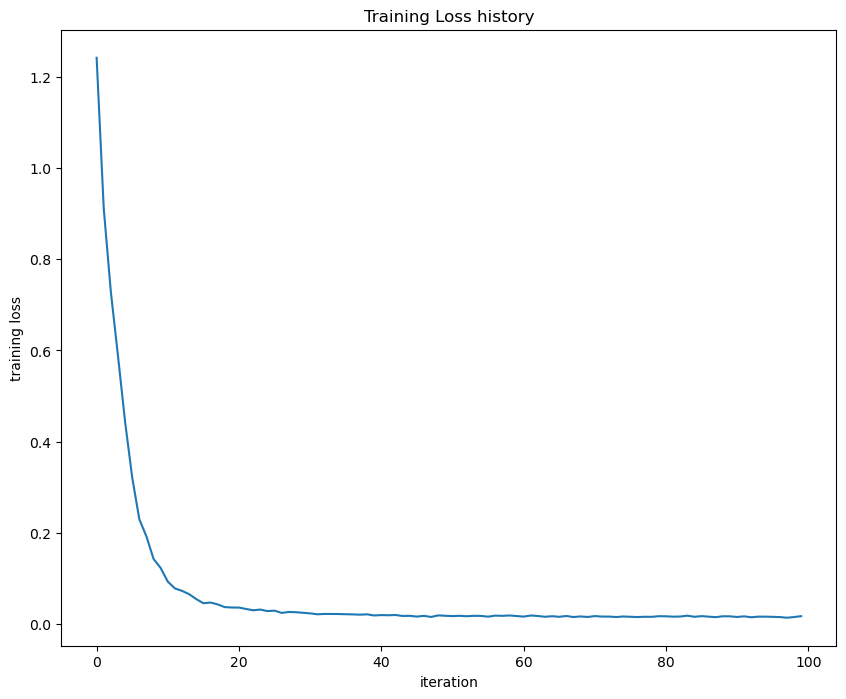

In [10]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])


plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

Обучение нейронной сети на реальном наборе данных (CIFAR-10, MNIST)

Загрузите набор данных, соответствующий вашему варианту. 

Разделите данные на обучающую, тестовую и валидационную выборки.

Выполните предобработку данных, как в ЛР 1. 

Обучите нейронную сеть на ваших данных. 

При сдаче лабораторной работы объясните значения всех параметров метода train.

In [11]:
# Загрузим датасет
digits = load_digits()
# Разделим данные на признаки и метки классов
X = digits.data
y = digits.target

# Определим количество классов
num_classes = len(set(y))

# Создадим словарь, в котором ключами будут классы, а значениями списки индексов соответствующих изображений
class_indices = {i: [] for i in range(num_classes)}
for i, label in enumerate(y):
    class_indices[int(label)].append(i)

# Разделение данных на обучающую, тестовую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Преобразование каждого изображения в одномерный массив
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat = X_val.reshape(len(X_val), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

# Вывод размеров полученных выборок
print("Размеры обучающей выборки:", X_train_flat.shape)
print("Размеры валидационной выборки:", X_val_flat.shape)
print("Размеры тестовой выборки:", X_test_flat.shape)

Размеры обучающей выборки: (1077, 64)
Размеры валидационной выборки: (360, 64)
Размеры тестовой выборки: (360, 64)


In [12]:
input_size = 64
hidden_size = 32
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

итерация 0 / 1000: потери 2.302591
итерация 100 / 1000: потери 2.302590
итерация 200 / 1000: потери 2.302588
итерация 300 / 1000: потери 2.302587
итерация 400 / 1000: потери 2.302593
итерация 500 / 1000: потери 2.302585
итерация 600 / 1000: потери 2.302588
итерация 700 / 1000: потери 2.302586
итерация 800 / 1000: потери 2.302597
итерация 900 / 1000: потери 2.302593
Validation accuracy:  0.08055555555555556


Используя параметры по умолчанию, вы можете получить accuracy, примерно равный 0.29. 

Проведите настройку гиперпараметров для увеличения accuracy. Поэкспериментируйте со значениями гиперпараметров, например, с количеством скрытых слоев, количеством эпох, скорости обучения и др. Ваша цель - максимально увеличить accuracy полносвязной сети на валидационном наборе. Различные эксперименты приветствуются. Например, вы можете использовать методы для сокращения размерности признакового пространства (например, PCA), добавить dropout слои и др. 

Для лучшей модели вычислите acсuracy на тестовом наборе. 

Для отладки процесса обучения часто помогают графики изменения loss и accuracy в процессе обучения. Ниже приведен код построения таких графиков. 

In [13]:

learning_rate_decays = [1]
learning_rates = [0.01]  # Различные значения скорости обучения
regularization_strengths = [0.01]  # Различные значения коэффициента регуляризации
batch_sizes = [400]  # Различные значения размера пакета
hidden_sizes = [256]  # Различные размеры скрытого слоя
num_iterss = [4000]

# Инициализация переменных для хранения лучших результатов
best_val_accuracy = -1
best_test_accuracy = -1
best_hyperparams = {}

# Создание DataFrame для хранения результатов поиска
df = pd.DataFrame({'hs': [],
                   'lr': [],
                   'rs': [],
                   'lrd': [],
                   'ni': [],
                   'bs': [],
                   'acc': []})
# Перебор всех комбинаций гиперпараметров
for hs, lr, reg, lrd, ni, bs in itertools.product(hidden_sizes, learning_rates, regularization_strengths, learning_rate_decays, num_iterss, batch_sizes):
    # Инициализация и обучение модели с текущими гиперпараметрами
    net = TwoLayerNet(input_size, hs, num_classes)
    stats = net.train(X_train, y_train, X_val, y_val,
                      num_iters=ni, batch_size=bs,
                      learning_rate=lr, learning_rate_decay=lrd,
                      reg=reg, verbose=False)

    # Оценка качества модели на валидационном и тестовом наборах данных
    val_accuracy = (net.predict(X_val) == y_val).mean()
    test_accuracy = (net.predict(X_test) == y_test).mean()
    params = {'hidden_size': hs, 'learning_rate': lr, 'reg': reg, 'learning_rate_decay': lrd, 'num_iters': ni, 'batch_size': bs}

    # Обновление лучших результатов, если текущая модель лучше
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_test_accuracy = test_accuracy
        best_hyperparams = params

    # Добавление результатов в DataFrame
    df = df.append({'hs': hs, 'lr': lr, 'rs': reg, 'lrd': lrd, 'ni': ni, 'bs': bs, 'acc': val_accuracy}, ignore_index=True)

# Вывод лучших результатов и результатов поиска
print("Лучшая точность на валидации:", best_val_accuracy)
print("Точность тестирования лучшей модели:", best_test_accuracy)
print("Лучшие гиперпараметры:", best_hyperparams)

# Вывод результатов поиска в DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print(df)


Лучшая точность на валидации: 0.9777777777777777
Точность тестирования лучшей модели: 0.9666666666666667
Лучшие гиперпараметры: {'hidden_size': 256, 'learning_rate': 0.01, 'reg': 0.01, 'learning_rate_decay': 1, 'num_iters': 4000, 'batch_size': 400}
      hs    lr    rs  lrd      ni     bs       acc
0  256.0  0.01  0.01  1.0  4000.0  400.0  0.977778


C:\Users\ibarsukov\AppData\Local\Temp\ipykernel_9912\4259329555.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'hs': hs, 'lr': lr, 'rs': reg, 'lrd': lrd, 'ni': ni, 'bs': bs, 'acc': val_accuracy}, ignore_index=True)


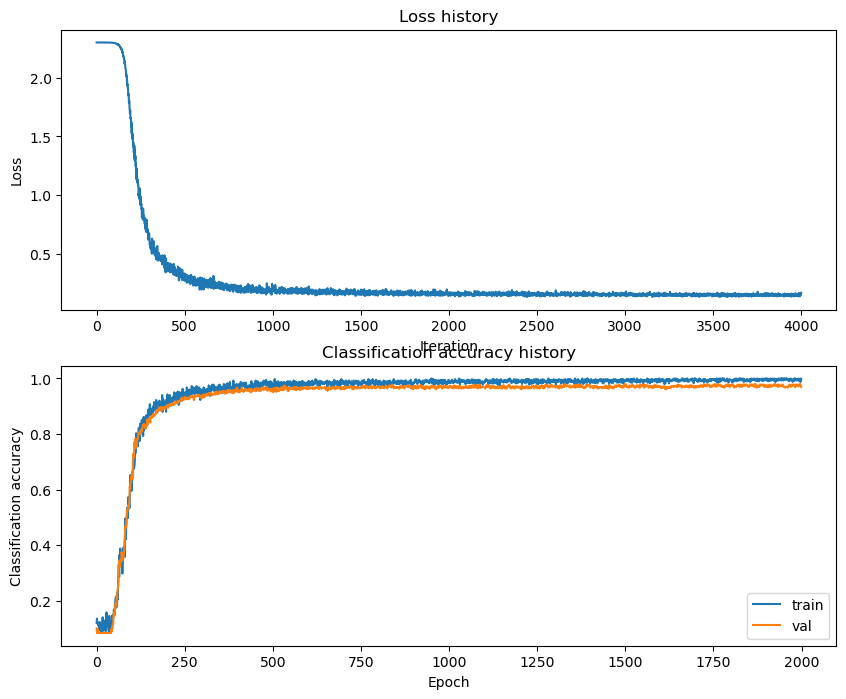

In [14]:
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

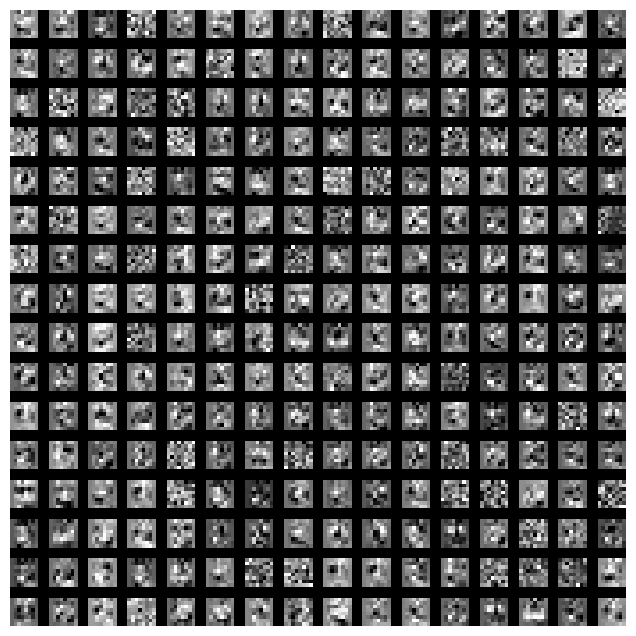

In [18]:

def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    Reshape a 4D tensor of image data to a grid for easy visualization.

    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                # grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding

    return grid
def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(8, 8, 1, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

На тестовых данных удалось получить высокий результат точности > 0.95. Однако параметры модели сильно взаимосвязаны, и наилучший результат достигается при одновременном подборе всех гиперпараметров, что требует значительного времени. Кроме того, не удалось выявить линейной зависимости между параметрами и точностью модели. Лучшие параметры:  {'hidden_size': 256, 'learning_rate': 0.01, 'reg': 0.01, 'learning_rate_decay': 1, 'num_iters': 4000, 'batch_size': 400}